In [2]:
import pandas as pd
import numpy as np
word_analysis_df = pd.read_csv("data/WordAnalysis.csv")
word_analysis_df['Examples'] = word_analysis_df['Happiness score']
word_analysis_df['Examples'][1:-1] = np.nan
word_analysis_df['Happiness score'][0] = np.nan
word_analysis_df['Happiness score'][-1:] = np.nan
print(word_analysis_df)

             Word  Happiness score  Times used  Weighted mean  Examples
0        Laughter              NaN         NaN            NaN      8.50
1             Fun             7.96        30.0           6.52       NaN
2      Excitement             7.62        20.0           6.52       NaN
3     Creativity*             7.40        21.0           6.52       NaN
4        Progress             7.26        11.0           6.52       NaN
5       Knowledge             7.24        18.0           6.52       NaN
6            Cool             7.20        11.0           6.52       NaN
7        Learning             6.92        33.0           6.52       NaN
8   Understanding             6.84        24.0           6.52       NaN
9       Discovery             6.54        69.0           6.52       NaN
10    Innovation*             6.46        21.0           6.52       NaN
11       Research             6.46        18.0           6.52       NaN
12   Exploration*             6.37        55.0           6.52   

<ipython-input-2-c3b1fcc1d5e9>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  word_analysis_df['Examples'][1:-1] = np.nan
<ipython-input-2-c3b1fcc1d5e9>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  word_analysis_df['Happiness score'][0] = np.nan
<ipython-input-2-c3b1fcc1d5e9>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  word_analysis_df['Happiness score'][-1:] = np.nan


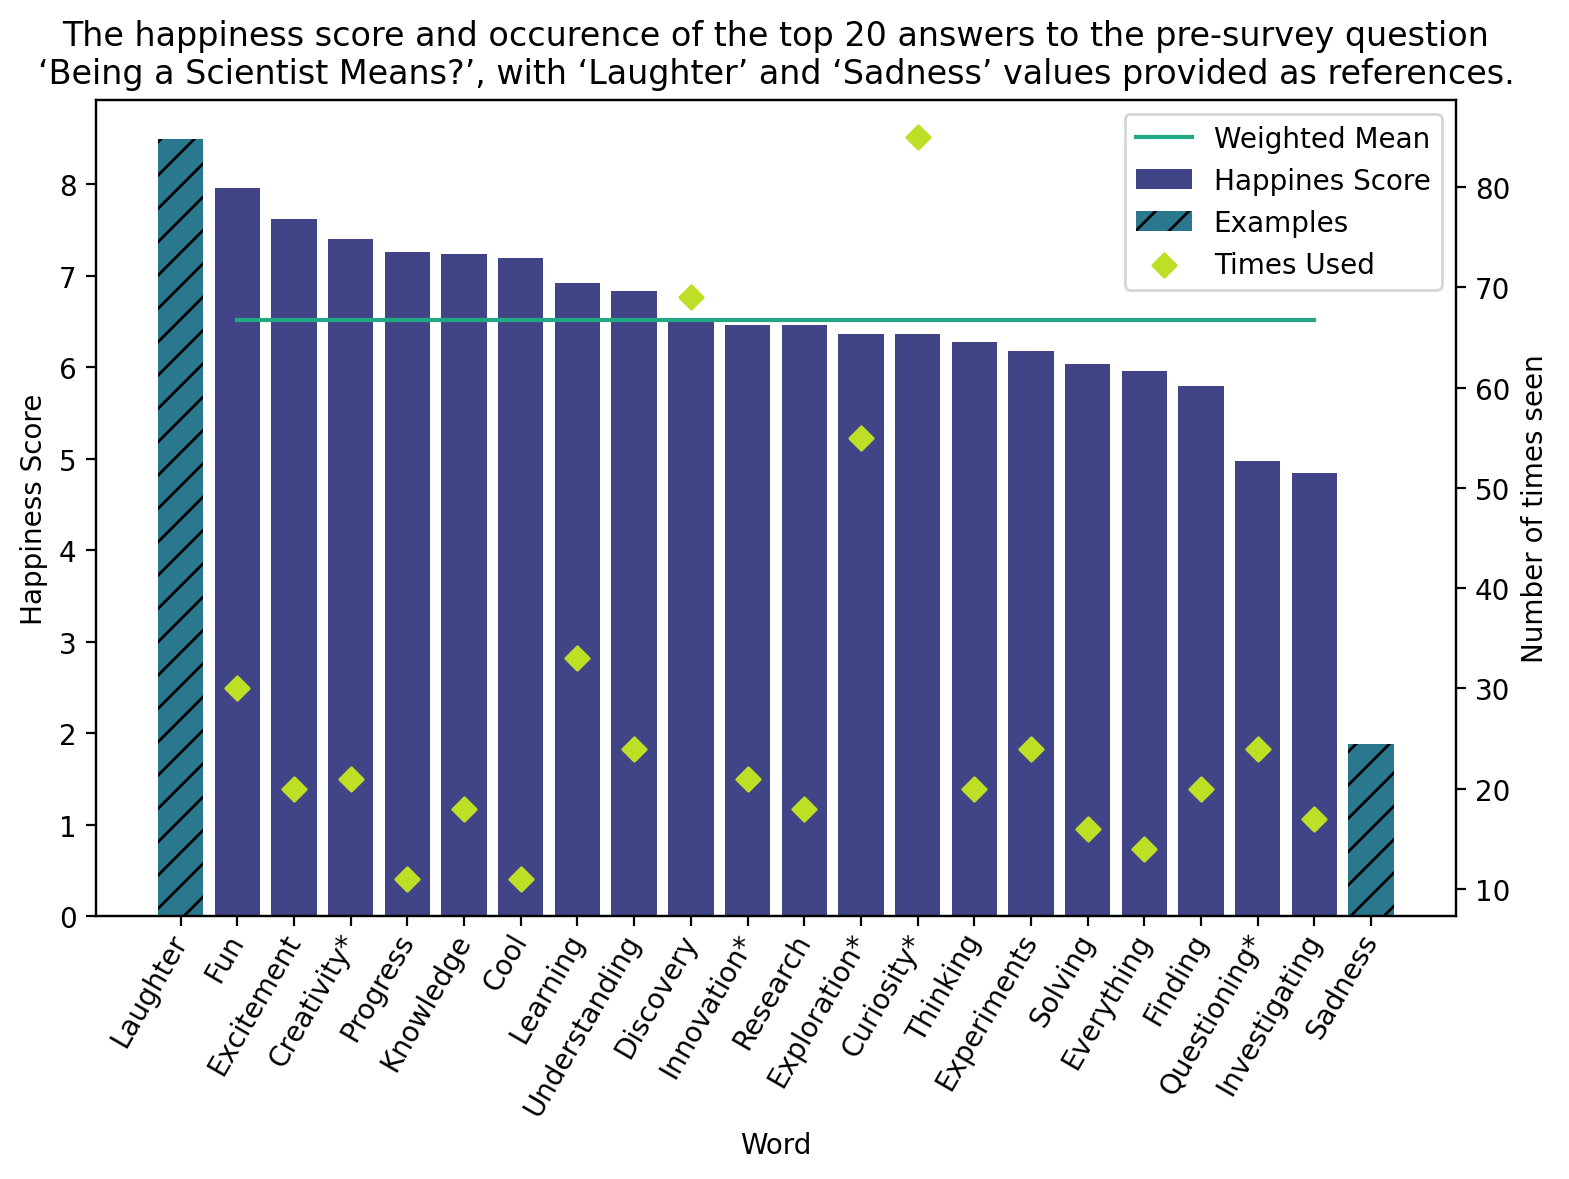

In [3]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pl

fig, ax = plt.subplots(figsize=(8, 6), dpi=200)
ax2=ax.twinx()

ax.bar(word_analysis_df['Word'],word_analysis_df['Happiness score'], color=pl.cm.viridis(0.2), label='Happines Score')
ax.bar(word_analysis_df['Word'],word_analysis_df['Examples'], color=pl.cm.viridis(0.4), label='Examples', hatch='//')
ax2.scatter(word_analysis_df['Word'],word_analysis_df['Times used'], color=pl.cm.viridis(0.9), marker='D', label='Times Used')
ax.plot(word_analysis_df['Word'],word_analysis_df['Weighted mean'], color=pl.cm.viridis(0.6), label='Weighted Mean')
ax.set_xlabel('Word')
ax.set_ylabel('Happiness Score')
ax2.set_ylabel('Number of times seen')
ax.set_title("The happiness score and occurence of the top 20 answers to the pre-survey question\n‘Being a Scientist Means?’, with ‘Laughter’ and ‘Sadness’ values provided as references.")

# Tweak spacing to prevent clipping of ylabel
fig.tight_layout()
plt.setp(ax.get_xticklabels(), rotation=60, ha="right", va='center',
         rotation_mode="anchor")

#legend dohicky
handles, labels = ax.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
handles += handles2
labels += labels2
plt.legend(handles, labels)
plt.tight_layout()
plt.savefig('figures/WordAnalyis.png')
plt.show()

In [6]:
[2]*5

[2, 2, 2, 2, 2]